# Sample notebook for ARCS

This notebook demonstrates how to use the ARCS library to perform a simulation on a chemical reaction network. 

In [1]:
from arcs.analysis import *
from arcs.setup_functions import *
from arcs.traversal import Traversal




In [2]:
## Load pickled graph and reactions
graph = pickle.load(open("../app/data/SCAN_graph.p", "rb"))

In [3]:
traversal = Traversal(graph=graph, reactions="../app/data/SCAN_reactions.p")

In [4]:
# Inputs
gic = GenerateInitialConcentrations(graph)
gic.all_zero(include_co2=False)
gic.update_ic({
    "SO2": 10e-6,
    "NO2": 50e-6, 
    "H2S": 30e-6, 
    "H2O": 20e-6
})
concs = gic.ic
settings = {
    "nprocs": 1,
    "sample_length": 320,
    "max_rank": 10,
    "max_compounds": 5,
    "probability_threshold": 0.1,
    "path_depth": 5,
    "ceiling": 2000,
    "scale_highest": 0.2,
    "rank_small_reactions_higher":True
}
trange=300
prange=10

In [5]:
# Run simulation
traversal.run(trange=[trange], prange=[prange], save=False, ic=concs, **settings)

In [6]:
df_d = (pd.DataFrame(traversal.initfinaldiff[trange][prange]))
display(df_d)

,initial,final,change
CO2,1000000.0,0.000000,0.000000
H2O,20.0,10.125993,-9.874007
H2S,30.0,11.807353,-18.192647
SO2,10.0,18.249940,8.249940
NO2,50.0,11.840828,-38.159172
H2,0.0,0.699100,0.699100
H2SO4,0.0,2.176749,2.176749
H2SO3,0.0,2.360635,2.360635
NH3,0.0,9.949705,9.949705
HNO2,0.0,10.258446,10.258446


In [7]:
### statistics 
analyse=AnalyseSampling(traversal.data, markdown=True)

analyse.mean_sampling()
analyse.reaction_paths()
analyse.reaction_statistics()

mean=analyse.mean_data[trange][prange]
paths=pd.DataFrame(analyse.common_paths[trange][prange])
stats=pd.DataFrame(analyse.stats[trange][prange])

df_m_t = pd.DataFrame(mean).T
df_m_t = df_m_t[df_m_t['value'] != 0]

df_m = pd.DataFrame(
    {
        "comps": list(df_m_t.T.keys()),
        "values": df_m_t['value'].values,
        "variance": df_m_t['variance'].values,
        "variance_minus": -df_m_t['variance'].values
    }
)
      

In [9]:

import plotly.express as px

fig = px.bar(
    df_m,
    x="comps",
    y="values",
    error_y="variance",
    error_y_minus="variance_minus",
    labels={"comps": "", "values": "\u0394 ppm"},
    color="values",
    color_continuous_scale="tropic_r",
    hover_data={
        "values": False,
        "comps": False,
        "variance": False,
        "error": (":.2e", df_m["variance"]),
        "specie": df_m["comps"],
        "PPM": (":.1f", df_m["values"]),
    },
    width=1000,height=500
)

fig.update_xaxes(showgrid=False, tickangle=-60, tickmode="linear")

In [10]:
display(paths)

,paths,k,frequency
0,7HNO<sub>2</sub> + NOHSO<sub>4</sub> = 3H<sub>...,2.47e-118 \n 1.27e-40,19
1,6HNO<sub>2</sub> + SO<sub>2</sub> = 2H<sub>2</...,5.22e-103 \n 1.27e-40,15
2,NH<sub>3</sub> + SO<sub>2</sub> = H<sub>2</sub...,1.27e-40 \n 2.42e-62,6
3,NH<sub>3</sub> + SO<sub>2</sub> = H<sub>2</sub...,1.27e-40 \n 2.52e-55,5
4,NH<sub>3</sub> + SO<sub>2</sub> = H<sub>2</sub...,1.27e-40 \n 1.35e-123,4
5,NH<sub>3</sub> + SO<sub>2</sub> = H<sub>2</sub...,1.27e-40 \n 1.86e-41,3
6,NH<sub>3</sub> + 3NOHSO<sub>4</sub> = H<sub>2<...,2.59e+16 \n 1.27e-40,2
7,8HNO<sub>2</sub> + 7SO<sub>2</sub> = H<sub>2</...,2.41e-10 \n 1.27e-40,1


In [11]:
display(stats)

,index,k,frequency
0,NH<sub>3</sub> + SO<sub>2</sub> = H<sub>2</sub...,1.27e-40,87
1,NH<sub>3</sub> + NOHSO<sub>4</sub> = H<sub>2</...,6.03e-56,63
2,7HNO<sub>2</sub> + NOHSO<sub>4</sub> = 3H<sub>...,2.47e-118,62
3,6HNO<sub>2</sub> + SO<sub>2</sub> = 2H<sub>2</...,5.22e-103,55
4,H<sub>2</sub>S + 3NO<sub>2</sub> = H<sub>2</su...,6.6e+42,47
...,...,...,...
109,H<sub>2</sub>SO<sub>4</sub> + N<sub>2</sub> = ...,2.08e-123,1
110,4NH<sub>3</sub> + 2NOHSO<sub>4</sub> = 7H<sub>...,2.61e-241,1
111,H<sub>2</sub>SO<sub>3</sub> + 4HNO<sub>2</sub>...,3.68e-12,1
112,4H<sub>2</sub>SO<sub>3</sub> + 2NO<sub>2</sub>...,9.23e+153,1


In [12]:
print(f"nodes: {len(traversal.graph[300][10].nodes())}")
print(f"edges: {len(traversal.graph[300][10].edges())}")

nodes: 9137
edges: 89922


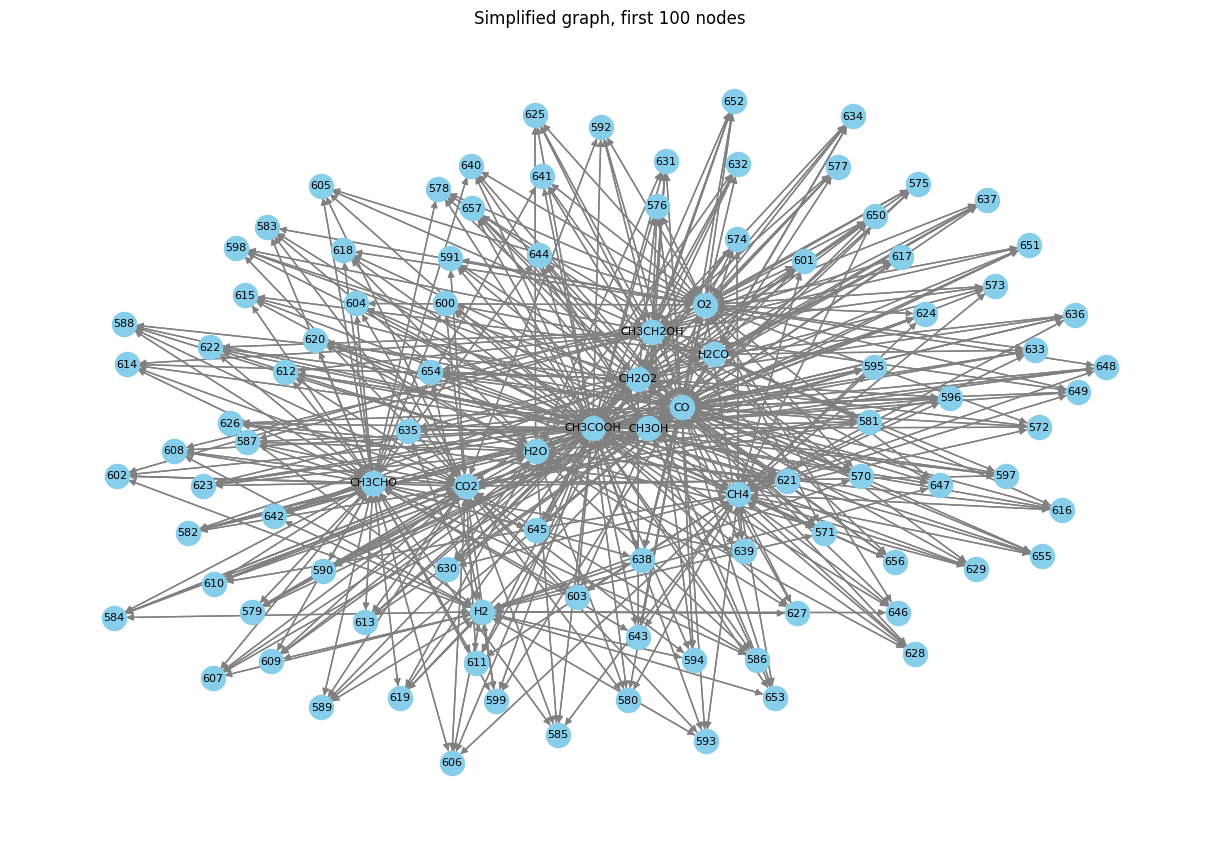

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

subgraph = traversal.graph[300][10]

# Simplify the graph for visualization, only first 100 nodes
simplified_subgraph = subgraph.subgraph(list(subgraph.nodes)[:100])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(simplified_subgraph)  
nx.draw(simplified_subgraph, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=8,edge_color="gray")
plt.title("Simplified graph, first 100 nodes")
plt.show()

In [14]:
nodes_filtered = {node: data for node, data in subgraph.nodes(data=True) if subgraph.degree(node) > 10}
print(nodes_filtered)

{'CH2O2': {}, 'CH3CH2OH': {}, 'CO': {}, 'H2': {}, 'O2': {}, 'CH3COOH': {}, 'CH3OH': {}, 'CH4': {}, 'CH3CHO': {}, 'H2CO': {}, 'CO2': {}, 'H2O': {}, 'H2SO4': {}, 'H2S': {}, 'S8': {}, 'SO2': {}, 'H2SO3': {}, 'HNO3': {}, 'NO2': {}, 'NH3': {}, 'HNO2': {}, 'NO': {}, 'N2': {}, 'NOHSO4': {}}


In [15]:

# Sort edges based on the weight attribute
sorted_edges = sorted(subgraph.edges(data=True), key=lambda x: x[2].get('weight', 0), reverse=True)

top_20_edges = sorted_edges[:20]
for edge in top_20_edges:
    print(edge)

('SO2', 43, {'weight': 3.8312774781154664})
(43, 'O2', {'weight': 3.8312774781154664})
(43, 'S8', {'weight': 3.8312774781154664})
('SO2', 5912, {'weight': 3.6511907690953103})
('N2', 5912, {'weight': 3.6511907690953103})
(5912, 'NO', {'weight': 3.6511907690953103})
(5912, 'O2', {'weight': 3.6511907690953103})
(5912, 'S8', {'weight': 3.6511907690953103})
('SO2', 5910, {'weight': 3.5856533396510555})
('N2', 5910, {'weight': 3.5856533396510555})
(5910, 'NO2', {'weight': 3.5856533396510555})
(5910, 'O2', {'weight': 3.5856533396510555})
(5910, 'S8', {'weight': 3.5856533396510555})
('H2SO4', 7125, {'weight': 3.4088623828279196})
('SO2', 7125, {'weight': 3.4088623828279196})
(7125, 'H2', {'weight': 3.4088623828279196})
(7125, 'O2', {'weight': 3.4088623828279196})
(7125, 'S8', {'weight': 3.4088623828279196})
('SO2', 8642, {'weight': 3.369556416120677})
('H2SO3', 8642, {'weight': 3.369556416120677})


In [16]:
# Filter edges with weight 
filtered_edges = [(u, v, data) for u, v, data in subgraph.edges(data=True) if data.get('weight', 0) > 3.2]

# Extract nodes connected by these edges
filtered_nodes = set()
for u, v, data in filtered_edges:
    filtered_nodes.add(u)
    filtered_nodes.add(v)

   

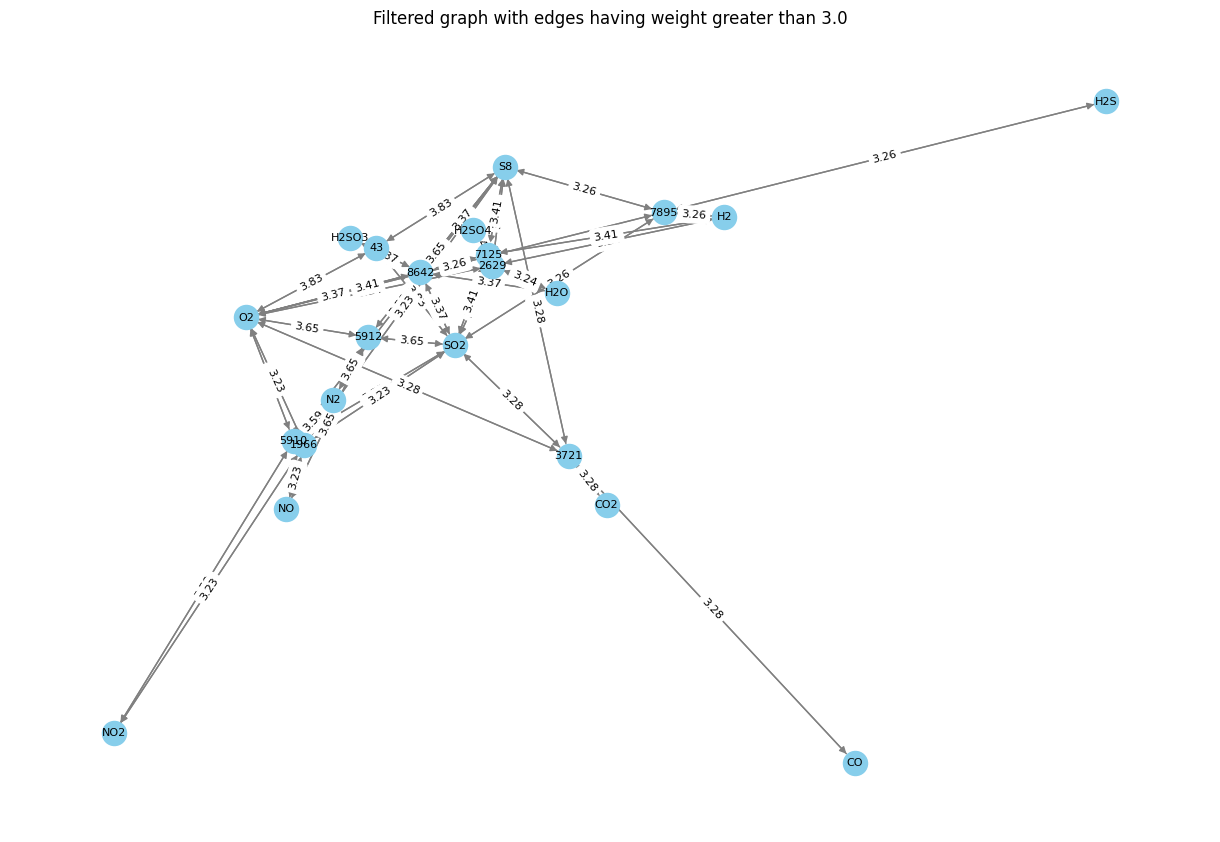

In [17]:
simplified_subgraph = subgraph.subgraph(filtered_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(simplified_subgraph) 
nx.draw(simplified_subgraph, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=8, edge_color="gray")


edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in filtered_edges}
nx.draw_networkx_edge_labels(simplified_subgraph, pos, edge_labels=edge_labels, font_size=8)


plt.title("Filtered graph with edges having weight greater than 3.0")
plt.show()